In [1]:
import os
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa
from pytorch_lightning import LightningDataModule
from torch.utils.data import Dataset, DataLoader


SAMPLE_RATE = 22050
plt.rcParams['figure.dpi'] = 120

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import whisper
import torch
from difflib import SequenceMatcher
import demucs.pretrained
import demucs.apply

class StudioLiveDataset(Dataset):
    def __init__(self, dataset_dir, segment_duration=5.0, num_segments=5, whisper_model="large", 
                 lyric_match_threshold=0.5):
        self.dataset_dir = dataset_dir
        self.studio_dir = os.path.join(dataset_dir, "studio")
        self.live_dir = os.path.join(dataset_dir, "live")
        self.segment_duration = segment_duration
        self.num_segments = num_segments
        self.segment_samples = int(segment_duration * SAMPLE_RATE)
        self.lyric_match_threshold = lyric_match_threshold
        
        self.has_gpu = torch.cuda.is_available()
        self.device = "cuda" if self.has_gpu else "cpu"
        
        self.separator = demucs.pretrained.get_model('htdemucs')
        self.separator.to("cuda")
        self.separator.eval()
        
        self.whisper_model = whisper.load_model(whisper_model, device=self.device)
        
        studio_files = sorted(os.listdir(self.studio_dir))
        live_files = sorted(os.listdir(self.live_dir))
        
        self.pairs = [{"studio_file": sf, "live_file": lf} 
                      for sf, lf in zip(studio_files, live_files) if sf == lf]
        
        self.pairs_cache = {}
        self.aligned_audio_cache = {}
        
        for pair in self.pairs:
            studio_file, live_file = pair["studio_file"], pair["live_file"]
            studio_path = os.path.join(self.studio_dir, studio_file)
            live_path = os.path.join(self.live_dir, live_file)
            
            print(f"\nProcessing: {studio_file}")
            studio_audio, _ = librosa.load(studio_path, sr=SAMPLE_RATE)
            live_audio, _ = librosa.load(live_path, sr=SAMPLE_RATE)
            
            aligned_studio, aligned_live, offset = self._align_audio_with_whisper(
                studio_audio, live_audio, studio_path, live_path)
            
            self.aligned_audio_cache[studio_file] = {
                "studio": aligned_studio, "live": aligned_live, "offset": offset}
            
            matched_segments = self._extract_and_match_segments(aligned_studio, aligned_live, offset)
            matched_segments = self._verify_segment_lyrics(aligned_studio, aligned_live, matched_segments)
            self.pairs_cache[studio_file] = matched_segments
    
    def _separate_vocals(self, audio):
        if not self.has_gpu:
            return audio
        try:
            audio_stereo = np.stack([audio, audio], axis=0) if audio.ndim == 1 else audio
            audio_tensor = torch.from_numpy(audio_stereo).float().cuda().unsqueeze(0)
            
            with torch.no_grad():
                sources = demucs.apply.apply_model(self.separator, audio_tensor, 
                                                   device="cuda", split=True, overlap=0.25)
            vocals = sources[0, 3].cpu().numpy()
            return np.mean(vocals, axis=0) if vocals.shape[0] == 2 else vocals
        except Exception as e:
            print(f"Vocal separation failed: {e}")
            return audio
    
    def _verify_segment_lyrics(self, studio_audio, live_audio, matched_segments):
        studio_segments = self._extract_all_segments(studio_audio)
        live_segments = self._extract_all_segments(live_audio)
        
        for seg_idx, seg_info in enumerate(matched_segments):
            studio_idx, live_idx = seg_info["studio_idx"], seg_info["live_idx"]
            studio_segment, live_segment = studio_segments[studio_idx], live_segments[live_idx]
            
            studio_text = self._transcribe_segment(studio_segment, f"studio_{studio_idx}")
            live_text = self._transcribe_segment(live_segment, f"live_{live_idx}")
            similarity = self._calculate_text_similarity(studio_text, live_text)
            
            seg_info.update({
                "studio_lyrics": studio_text, "live_lyrics": live_text,
                "lyric_similarity": similarity, "lyrics_verified": similarity >= self.lyric_match_threshold
            })
            
            print(f"  Seg {studio_idx}->{live_idx}: {'✓' if seg_info['lyrics_verified'] else '✗'} (sim={similarity:.2f})")
        
        return matched_segments
    
    def _transcribe_segment(self, audio_segment, debug_label=""):
        try:
            if len(audio_segment) < SAMPLE_RATE * 0.1 or np.sqrt(np.mean(audio_segment ** 2)) < 1e-6:
                return ""
            
            vocals = self._separate_vocals(audio_segment)
            print(f"{debug_label}: vocals RMS = {np.sqrt(np.mean(vocals**2))}")
            audio_float32 = vocals.astype(np.float32)
            max_val = np.abs(audio_float32).max()
            if max_val > 1.0 or max_val < 0.01:
                audio_float32 = audio_float32 / max(max_val, 1e-10)
            
            result = self.whisper_model.transcribe(audio_float32, language="en", 
                                                   word_timestamps=False, fp16=True, verbose=False)
            return result.get("text", "").strip().lower().replace("<|endoftext|>", "").replace("<|id|>", "").strip()
        except Exception as e:
            print(f"{debug_label} error: {e}")
            return ""
    
    def _calculate_text_similarity(self, text1, text2):
        if not text1 and not text2: return 1.0
        if not text1 or not text2: return 0.0
        return SequenceMatcher(None, text1, text2).ratio()
    
    def get_aligned_audio(self, idx):
        return self.aligned_audio_cache[self.pairs[idx]["studio_file"]]
    
    def get_segment_audio(self, idx, segment_idx):
        studio_file = self.pairs[idx]["studio_file"]
        aligned_audio = self.aligned_audio_cache[studio_file]
        
        studio_segments = self._extract_all_segments(aligned_audio["studio"])
        live_segments = self._extract_all_segments(aligned_audio["live"])
        seg_info = self.pairs_cache[studio_file][segment_idx]
        
        return {
            "studio_audio": studio_segments[seg_info["studio_idx"]],
            "live_audio": live_segments[seg_info["live_idx"]],
            **{k: seg_info[k] for k in ["studio_idx", "live_idx", "mse_cost", 
                                        "studio_lyrics", "live_lyrics", 
                                        "lyric_similarity", "lyrics_verified"]}
        }
    
    def _align_audio_with_whisper(self, studio_audio, live_audio, studio_path, live_path):
        studio_result = self.whisper_model.transcribe(studio_path, word_timestamps=True, fp16=False, verbose=False)
        live_result = self.whisper_model.transcribe(live_path, word_timestamps=True, fp16=False, verbose=False)
        
        studio_words = self._extract_word_timestamps(studio_result)
        live_words = self._extract_word_timestamps(live_result)
        
        if not studio_words or not live_words:
            return studio_audio, live_audio, 0.0
        
        offset = self._calculate_time_offset(studio_words, live_words)
        print(f"  Offset: {offset:.2f}s")
        
        aligned_live = self._apply_time_offset(live_audio, offset)
        min_length = min(len(studio_audio), len(aligned_live))
        
        return studio_audio[:min_length], aligned_live[:min_length], offset
    
    def _extract_word_timestamps(self, whisper_result):
        return [{"word": w["word"].strip().lower(), "start": w["start"], "end": w["end"]}
                for seg in whisper_result.get("segments", []) for w in seg.get("words", [])]
    
    def _calculate_time_offset(self, studio_words, live_words):
        matches = [(i, j) for i, sw in enumerate(studio_words) 
                   for j, lw in enumerate(live_words) 
                   if sw["word"] == lw["word"] and len(sw["word"]) > 2]
        
        if not matches: return 0.0
        offsets = [live_words[j]["start"] - studio_words[i]["start"] for i, j in matches]
        return np.median(offsets)
    
    def _apply_time_offset(self, audio, offset_seconds):
        offset_samples = int(offset_seconds * SAMPLE_RATE)
        if offset_samples > 0:
            return audio[offset_samples:] if offset_samples < len(audio) else np.zeros(1)
        elif offset_samples < 0:
            return np.concatenate([np.zeros(-offset_samples), audio])
        return audio
    
    def _extract_and_match_segments(self, studio_audio, live_audio, time_offset):
        studio_segments = self._extract_all_segments(studio_audio)
        live_segments = self._extract_all_segments(live_audio)
        
        if not studio_segments or not live_segments:
            return self._create_empty_segments()
        
        studio_specs = [self._audio_to_mel(seg) for seg in studio_segments]
        live_specs = [self._audio_to_mel(seg) for seg in live_segments]
        
        max_segment_diff = int(10.0 / self.segment_duration)
        cost_matrix = np.array([[np.mean((ss - ls) ** 2) if abs(i - j) <= max_segment_diff else np.inf
                                for j, ls in enumerate(live_specs)] for i, ss in enumerate(studio_specs)])
        
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        matched_pairs = [(i, j, cost_matrix[i, j]) for i, j in zip(row_ind, col_ind) if cost_matrix[i, j] != np.inf]
        matched_pairs.sort(key=lambda x: x[2])
        
        best_matches = matched_pairs[:self.num_segments]
        while len(best_matches) < self.num_segments:
            best_matches.append(matched_pairs[len(best_matches) % len(matched_pairs)] if matched_pairs else (0, 0, 0))
        
        return [{"studio_spec": torch.tensor(studio_specs[si], dtype=torch.float32),
                "live_spec": torch.tensor(live_specs[li], dtype=torch.float32),
                "mse_cost": cost, "studio_idx": si, "live_idx": li}
                for si, li, cost in best_matches]
    
    def _extract_all_segments(self, audio):
        return [audio[i*self.segment_samples:(i+1)*self.segment_samples] 
                for i in range(len(audio) // self.segment_samples)]
    
    def _audio_to_mel(self, audio):
        mel = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=1.0)
        mel_norm = 2.0 * (np.clip(mel_db, -80.0, 20.0) + 80.0) / 100.0 - 1.0
        return mel_norm
    
    def _create_empty_segments(self):
        silent_spec = self._audio_to_mel(np.zeros(self.segment_samples))
        return [{"studio_spec": torch.tensor(silent_spec, dtype=torch.float32),
                "live_spec": torch.tensor(silent_spec, dtype=torch.float32),
                "mse_cost": 0.0, "studio_idx": 0, "live_idx": 0,
                "studio_lyrics": "", "live_lyrics": "", "lyric_similarity": 0.0, "lyrics_verified": False}
                for _ in range(self.num_segments)]
    
    def __getitem__(self, idx):
        segments = self.pairs_cache[self.pairs[idx]["studio_file"]]
        return {
            "studio_spec": torch.stack([s["studio_spec"] for s in segments]),
            "live_spec": torch.stack([s["live_spec"] for s in segments]),
            "mse_costs": torch.tensor([s["mse_cost"] for s in segments], dtype=torch.float32),
            "lyric_similarities": torch.tensor([s["lyric_similarity"] for s in segments], dtype=torch.float32),
            "lyrics_verified": torch.tensor([s["lyrics_verified"] for s in segments], dtype=torch.bool),
            "filename": self.pairs[idx]["studio_file"]
        }
    
    def __len__(self):
        return len(self.pairs)

In [3]:
dataset = StudioLiveDataset("../../dataset copy",
    whisper_model="small", 
    num_segments=5,
    
)
print(f"Dataset size: {len(dataset)}")
print(f"Example mel shape: {dataset[0]['studio_spec'].shape}")


Processing: After Hours.mp3
Detected language: English


100%|██████████| 36192/36192 [00:08<00:00, 4369.47frames/s]


Detected language: English


100%|██████████| 26791/26791 [00:05<00:00, 4783.07frames/s]


  Offset: -92.68s
studio_37: vocals RMS = 0.0004155193455517292


  0%|          | 0/689 [00:00<?, ?frames/s]


live_37: vocals RMS = 0.0019894023425877094


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 37->37: ✓ (sim=1.00)


studio_51: vocals RMS = 0.07054191827774048


  0%|          | 0/689 [00:00<?, ?frames/s]


live_51: vocals RMS = 0.012661520391702652


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 51->51: ✓ (sim=1.00)


studio_48: vocals RMS = 0.01695283129811287


  0%|          | 0/689 [00:00<?, ?frames/s]


live_48: vocals RMS = 0.001064433017745614


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 48->48: ✓ (sim=1.00)


studio_47: vocals RMS = 0.001623591291718185


  0%|          | 0/689 [00:00<?, ?frames/s]


live_47: vocals RMS = 0.00031430026865564287


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 47->47: ✓ (sim=1.00)


studio_39: vocals RMS = 0.056774597615003586


100%|██████████| 689/689 [00:00<00:00, 3871.86frames/s]


live_39: vocals RMS = 0.037716642022132874


100%|██████████| 689/689 [00:00<00:00, 1635.66frames/s]


  Seg 39->39: ✗ (sim=0.06)

Processing: Alone Again.mp3
Detected language: English


100%|██████████| 25110/25110 [00:04<00:00, 5945.48frames/s]


Detected language: English


 82%|████████▏ | 13740/16725 [00:08<00:01, 1700.14frames/s]


  Offset: -20.05s
studio_35: vocals RMS = 0.000146691279951483


  0%|          | 0/689 [00:00<?, ?frames/s]


live_36: vocals RMS = 0.0001240569690708071


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 35->36: ✓ (sim=1.00)


studio_32: vocals RMS = 0.00015723402611911297


  0%|          | 0/689 [00:00<?, ?frames/s]


live_32: vocals RMS = 0.00011520678526721895


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 32->32: ✓ (sim=1.00)


studio_33: vocals RMS = 0.00016078476619441062


  0%|          | 0/689 [00:00<?, ?frames/s]


live_31: vocals RMS = 0.00010223512072116137


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 33->31: ✓ (sim=1.00)


studio_34: vocals RMS = 0.00014499950339086354


  0%|          | 0/689 [00:00<?, ?frames/s]


live_35: vocals RMS = 0.00017995774396695197


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 34->35: ✓ (sim=1.00)


studio_36: vocals RMS = 0.00016017314919736236


  0%|          | 0/689 [00:00<?, ?frames/s]


live_34: vocals RMS = 0.00019690327462740242


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 36->34: ✓ (sim=1.00)

Processing: Blinding Lights.mp3


Detected language: English


100%|██████████| 20320/20320 [00:04<00:00, 4528.09frames/s]


Detected language: English


 88%|████████▊ | 22336/25336 [00:06<00:00, 3440.12frames/s]


  Offset: 50.66s
studio_18: vocals RMS = 0.0004184377321507782


  0%|          | 0/689 [00:00<?, ?frames/s]


live_18: vocals RMS = 0.000323712476529181


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 18->18: ✓ (sim=1.00)


studio_14: vocals RMS = 0.035669781267642975


  0%|          | 0/689 [00:00<?, ?frames/s]


live_14: vocals RMS = 0.0022348801139742136


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 14->14: ✓ (sim=1.00)


studio_28: vocals RMS = 0.006231964565813541


  0%|          | 0/689 [00:00<?, ?frames/s]


live_28: vocals RMS = 0.010746574029326439


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 28->28: ✓ (sim=1.00)


studio_25: vocals RMS = 0.03121039643883705


  0%|          | 0/689 [00:00<?, ?frames/s]


live_25: vocals RMS = 0.00040338680264540017


  0%|          | 0/689 [00:00<?, ?frames/s]

  Seg 25->25: ✓ (sim=1.00)


studio_27: vocals RMS = 0.01930532231926918


  0%|          | 0/689 [00:00<?, ?frames/s]


live_27: vocals RMS = 0.008274382911622524


100%|██████████| 689/689 [00:00<00:00, 1858.66frames/s]

  Seg 27->27: ✗ (sim=0.00)
Dataset size: 3
Example mel shape: torch.Size([5, 128, 216])


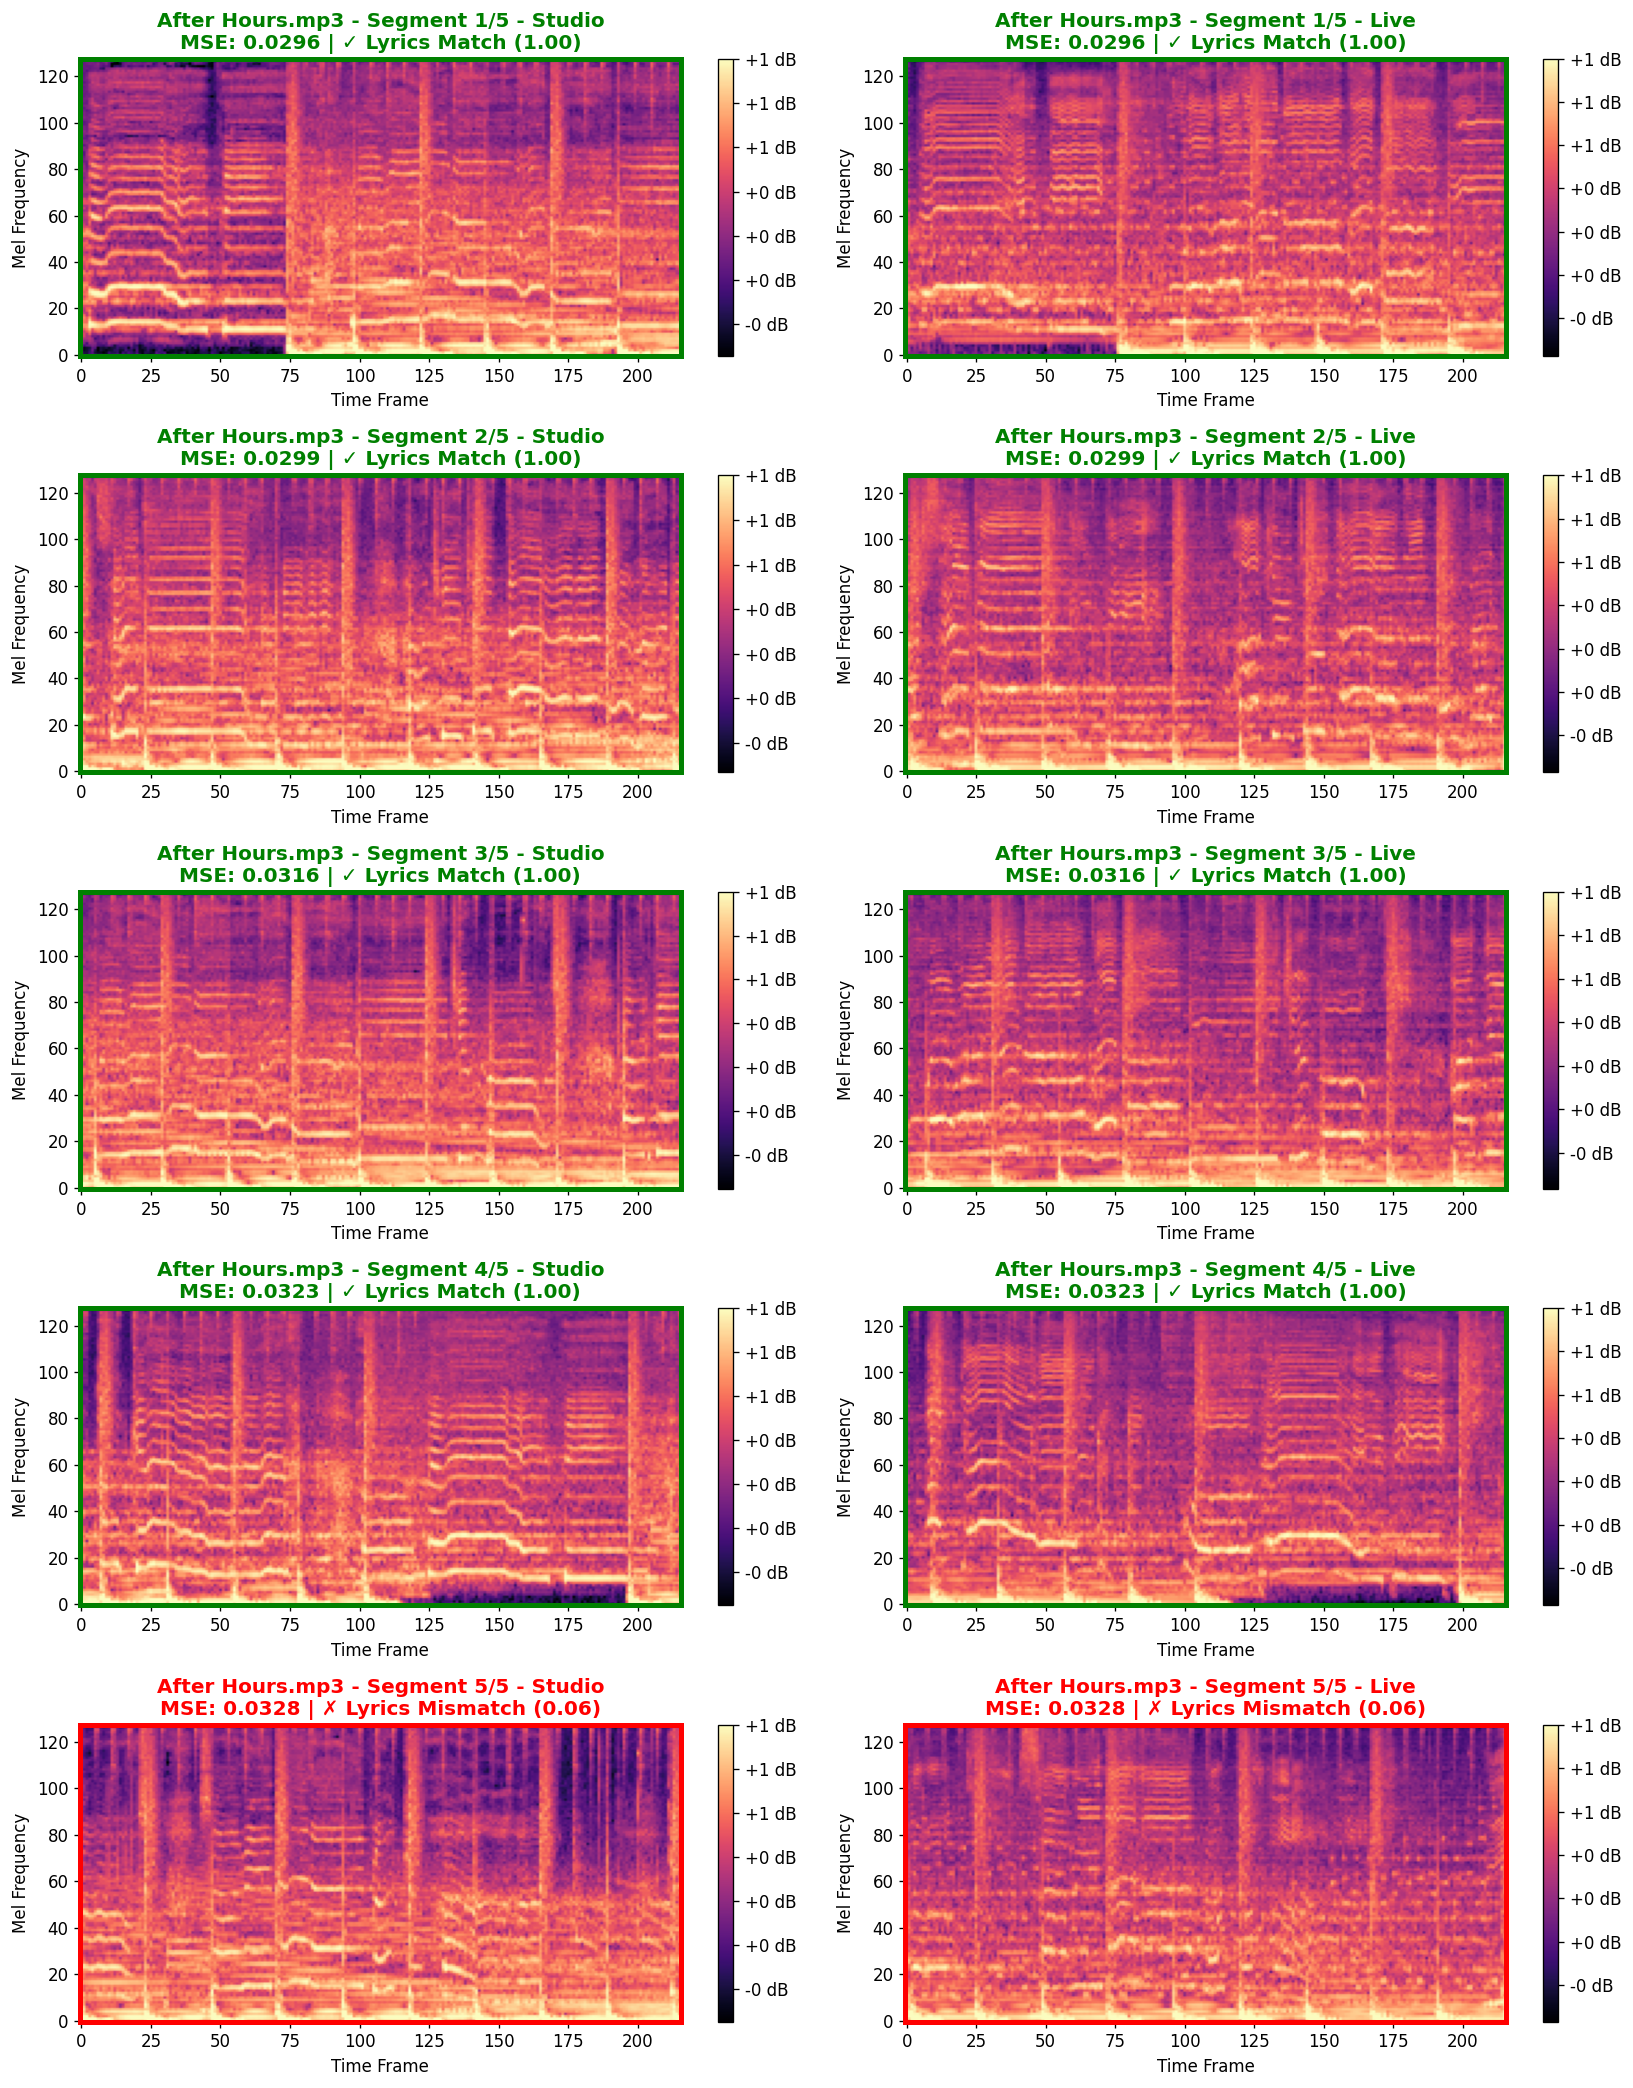


DATASET SHAPE VERIFICATION WITH LYRIC VERIFICATION

Item 0 (After Hours.mp3):
  Studio Spec Shape:      (5, 128, 216)
  Live Spec Shape:        (5, 128, 216)
  MSE Costs Shape:        (5,)
  Lyric Similarities:     (5,)
  Lyrics Verified:        (5,)

  MSE Costs:              [0.02956145 0.0299488  0.03160688 0.03226224 0.03277498]
  Lyric Similarities:     [1.         1.         1.         1.         0.06060606]
  Verification Status:    [ True  True  True  True False]
  Verified Segments:      4/5

Studio shapes across all items: [torch.Size([5, 128, 216])]
Live shapes across all items:   [torch.Size([5, 128, 216])]

DETAILED LYRIC VERIFICATION REPORT

After Hours.mp3:
------------------------------------------------------------

Segment 1 [✓ VERIFIED]:
  Indices: Studio[37] → Live[37]
  Similarity: 1.000
  Studio: ''
  Live:   ''

Segment 2 [✓ VERIFIED]:
  Indices: Studio[51] → Live[51]
  Similarity: 1.000
  Studio: ''
  Live:   ''

Segment 3 [✓ VERIFIED]:
  Indices: Studio[48] → 

🎵 Live audio:



--- Segment 2/5 [✓] ---
MSE: 0.0299 | Lyric Similarity: 1.000
Studio: segment 51 (255.0s - 260.0s)
Live:   segment 51 (255.0s - 260.0s)
Time difference: 0.0s
Studio lyrics: ''
Live lyrics:   ''
🎵 Studio audio:


🎵 Live audio:



--- Segment 3/5 [✓] ---
MSE: 0.0316 | Lyric Similarity: 1.000
Studio: segment 48 (240.0s - 245.0s)
Live:   segment 48 (240.0s - 245.0s)
Time difference: 0.0s
Studio lyrics: ''
Live lyrics:   ''
🎵 Studio audio:


🎵 Live audio:



--- Segment 4/5 [✓] ---
MSE: 0.0323 | Lyric Similarity: 1.000
Studio: segment 47 (235.0s - 240.0s)
Live:   segment 47 (235.0s - 240.0s)
Time difference: 0.0s
Studio lyrics: ''
Live lyrics:   ''
🎵 Studio audio:


🎵 Live audio:



--- Segment 5/5 [✗] ---
MSE: 0.0328 | Lyric Similarity: 0.061
Studio: segment 39 (195.0s - 200.0s)
Live:   segment 39 (195.0s - 200.0s)
Time difference: 0.0s
Studio lyrics: 'i'm sorry. i'm sorry. i'm sorry.'
Live lyrics:   '.'
🎵 Studio audio:


🎵 Live audio:



Verification complete!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Audio

SAMPLE_RATE = 22050
num_items = 1
num_segments = 5

fig, axes = plt.subplots(num_items * num_segments, 2, figsize=(14, 3.5 * num_items * num_segments))

for i in range(num_items):
    item = dataset[i]
    studio_specs = item["studio_spec"].numpy()  # (5, n_mels, time_frames)
    live_specs = item["live_spec"].numpy()      # (5, n_mels, time_frames)
    mse_costs = item["mse_costs"].numpy()       # (5,)
    lyric_similarities = item["lyric_similarities"].numpy()  # (5,)
    lyrics_verified = item["lyrics_verified"].numpy()  # (5,)
    filename = item.get("filename", f"pair_{i}")
    
    for seg_idx in range(num_segments):
        row_idx = i * num_segments + seg_idx
        
        studio_spec = studio_specs[seg_idx]  # (n_mels, time_frames)
        live_spec = live_specs[seg_idx]      # (n_mels, time_frames)
        mse_cost = mse_costs[seg_idx]
        lyric_sim = lyric_similarities[seg_idx]
        verified = lyrics_verified[seg_idx]
        
        if num_items * num_segments > 1:
            ax1 = axes[row_idx, 0]
            ax2 = axes[row_idx, 1]
        else:
            ax1 = axes[0]
            ax2 = axes[1]
        
        border_color = 'green' if verified else 'red'
        verification_text = f"✓ Lyrics Match ({lyric_sim:.2f})" if verified else f"✗ Lyrics Mismatch ({lyric_sim:.2f})"
        
        img1 = ax1.imshow(studio_spec, aspect='auto', origin='lower', cmap='magma')
        ax1.set_title(
            f"{filename} - Segment {seg_idx+1}/5 - Studio\nMSE: {mse_cost:.4f} | {verification_text}",
            color=border_color,
            fontweight='bold'
        )
        ax1.set_ylabel('Mel Frequency')
        ax1.set_xlabel('Time Frame')
        for spine in ax1.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
        fig.colorbar(img1, ax=ax1, format='%+2.0f dB')
        
        img2 = ax2.imshow(live_spec, aspect='auto', origin='lower', cmap='magma')
        ax2.set_title(
            f"{filename} - Segment {seg_idx+1}/5 - Live\nMSE: {mse_cost:.4f} | {verification_text}",
            color=border_color,
            fontweight='bold'
        )
        ax2.set_ylabel('Mel Frequency')
        ax2.set_xlabel('Time Frame')
        for spine in ax2.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
        fig.colorbar(img2, ax=ax2, format='%+2.0f dB')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DATASET SHAPE VERIFICATION WITH LYRIC VERIFICATION")
print("="*60)

for i in range(num_items):
    item = dataset[i]
    studio_specs = item["studio_spec"].numpy()
    live_specs = item["live_spec"].numpy()
    mse_costs = item["mse_costs"].numpy()
    lyric_similarities = item["lyric_similarities"].numpy()
    lyrics_verified = item["lyrics_verified"].numpy()
    
    print(f"\nItem {i} ({item.get('filename', 'N/A')}):")
    print(f"  Studio Spec Shape:      {studio_specs.shape}")
    print(f"  Live Spec Shape:        {live_specs.shape}")
    print(f"  MSE Costs Shape:        {mse_costs.shape}")
    print(f"  Lyric Similarities:     {lyric_similarities.shape}")
    print(f"  Lyrics Verified:        {lyrics_verified.shape}")
    print(f"\n  MSE Costs:              {mse_costs}")
    print(f"  Lyric Similarities:     {lyric_similarities}")
    print(f"  Verification Status:    {lyrics_verified}")
    print(f"  Verified Segments:      {np.sum(lyrics_verified)}/{len(lyrics_verified)}")
    
    for seg_idx in range(studio_specs.shape[0]):
        studio_seg_shape = studio_specs[seg_idx].shape
        live_seg_shape = live_specs[seg_idx].shape
        assert studio_seg_shape == live_seg_shape, \
            f"Segment {seg_idx} shape mismatch: {studio_seg_shape} vs {live_seg_shape}"

studio_shapes = [dataset[i]['studio_spec'].shape for i in range(num_items)]
live_shapes = [dataset[i]['live_spec'].shape for i in range(num_items)]

print("\n" + "="*60)
print("Studio shapes across all items:", studio_shapes)
print("Live shapes across all items:  ", live_shapes)
print("="*60)

assert len(set(studio_shapes)) == 1, f"Studio specs have varying shapes: {set(studio_shapes)}"
assert len(set(live_shapes)) == 1, f"Live specs have varying shapes: {set(live_shapes)}"
assert studio_shapes == live_shapes, f"Studio and live shapes mismatch: {studio_shapes} vs {live_shapes}"

print("\n" + "="*60)
print("DETAILED LYRIC VERIFICATION REPORT")
print("="*60)

for i in range(num_items):
    pair = dataset.pairs[i]
    studio_file = pair["studio_file"]
    matched_segments = dataset.pairs_cache[studio_file]
    
    print(f"\n{studio_file}:")
    print("-" * 60)
    
    for seg_idx, segment_info in enumerate(matched_segments):
        studio_idx = segment_info["studio_idx"]
        live_idx = segment_info["live_idx"]
        studio_lyrics = segment_info.get("studio_lyrics", "")
        live_lyrics = segment_info.get("live_lyrics", "")
        similarity = segment_info.get("lyric_similarity", 0.0)
        verified = segment_info.get("lyrics_verified", False)
        
        status_icon = "✓" if verified else "✗"
        status_color = "VERIFIED" if verified else "MISMATCH"
        
        print(f"\nSegment {seg_idx + 1} [{status_icon} {status_color}]:")
        print(f"  Indices: Studio[{studio_idx}] → Live[{live_idx}]")
        print(f"  Similarity: {similarity:.3f}")
        print(f"  Studio: '{studio_lyrics}'")
        print(f"  Live:   '{live_lyrics}'")

print("\n" + "="*60)

print("\n" + "="*60)
print("AUDIO SEGMENT PLAYBACK WITH LYRIC VERIFICATION")
print("="*60)

for i in range(num_items):
    item = dataset[i]
    filename = item.get("filename", f"pair_{i}")
    
    aligned_audio = dataset.get_aligned_audio(i)
    offset = aligned_audio["offset"]
    
    print(f"\n{'='*60}")
    print(f"Item {i}: {filename}")
    print(f"Alignment offset: {offset:.2f}s")
    print(f"{'='*60}")
    
    for seg_idx in range(num_segments):
        segment_data = dataset.get_segment_audio(i, seg_idx)
        
        studio_audio = segment_data["studio_audio"]
        live_audio = segment_data["live_audio"]
        studio_idx = segment_data["studio_idx"]
        live_idx = segment_data["live_idx"]
        mse_cost = segment_data["mse_cost"]
        studio_lyrics = segment_data["studio_lyrics"]
        live_lyrics = segment_data["live_lyrics"]
        lyric_similarity = segment_data["lyric_similarity"]
        lyrics_verified = segment_data["lyrics_verified"]
        
        studio_time_start = studio_idx * dataset.segment_duration
        studio_time_end = (studio_idx + 1) * dataset.segment_duration
        live_time_start = live_idx * dataset.segment_duration
        live_time_end = (live_idx + 1) * dataset.segment_duration
        time_diff = abs(studio_idx - live_idx) * dataset.segment_duration
        
        status_icon = "✓" if lyrics_verified else "✗"
        
        print(f"\n--- Segment {seg_idx+1}/{num_segments} [{status_icon}] ---")
        print(f"MSE: {mse_cost:.4f} | Lyric Similarity: {lyric_similarity:.3f}")
        print(f"Studio: segment {studio_idx} ({studio_time_start:.1f}s - {studio_time_end:.1f}s)")
        print(f"Live:   segment {live_idx} ({live_time_start:.1f}s - {live_time_end:.1f}s)")
        print(f"Time difference: {time_diff:.1f}s")
        print(f"Studio lyrics: '{studio_lyrics}'")
        print(f"Live lyrics:   '{live_lyrics}'")
        print("🎵 Studio audio:")
        display(Audio(studio_audio, rate=SAMPLE_RATE))
        print("🎵 Live audio:")
        display(Audio(live_audio, rate=SAMPLE_RATE))

print("\n" + "="*60)
print("Verification complete!")
print("="*60)